made directory at /home/pi/RISE/data3
--- 0.10273981094360352 seconds to save data ---
--- 0.09883499145507812 seconds to save data ---
--- 0.09851408004760742 seconds to save data ---
--- 0.09816908836364746 seconds to save data ---
done sir


<AxesSubplot:xlabel='time'>

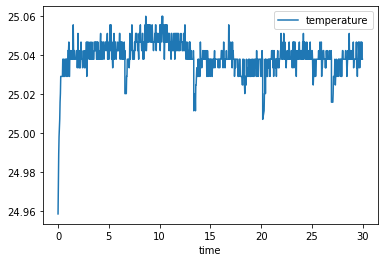

In [13]:
import os
import glob
import numpy as np
import board
import busio
import adafruit_bmp3xx
import adafruit_lsm303_accel
import adafruit_lsm303dlh_mag
import time
import picamera
import pandas as pd

# Setup a directory to save the data in

main_dir = os.listdir('/home/pi/RISE')

names = np.array([0])

for name in main_dir:
    if name.startswith('data'):
        name = np.array([name[4:]]).astype(np.int)
        names = np.append(names, name, axis=0).astype(np.int)

data_dir = f'/home/pi/RISE/data{np.max(names) + 1}'

os.mkdir(data_dir)

print('made directory at ' + data_dir)

# Set up I2C and sensors

i2c = busio.I2C(board.SCL, board.SDA)
bmp = adafruit_bmp3xx.BMP3XX_I2C(i2c)
accel = adafruit_lsm303_accel.LSM303_Accel(i2c)
mag = adafruit_lsm303dlh_mag.LSM303DLH_Mag(i2c)

# Set up camera stuff
### MAYBE ALSO ITERATE THE CAMERA RECORDINGS ###
### Format the recordings somehow ###
# cam = picamera.PiCamera() #intialize camera
# cam.resolution = (640, 480)
# camera.framerate = 90
# cam.start_recording(data_dir + '/' + 'video.h264') #start recording and name video file

# Define the time parameters

start_time = time.time()
delay_time = 10
record_time = 30

# iterating parameters

i = 0

## find a good interval for this value
iters = 200

# Define the array with all of the data

# Define the function to save a temporary file
def saveTempFile():
    # the formatting (the '{:03}') allows for up to 999 temp files
    file = open(data_dir + '/data' + '{:03}'.format(int(i / iters)) + '.csv', "w")
    np.savetxt(data_dir + '/data' + '{:03}'.format(int(i / iters)) + '.csv', datas, delimiter=",")
    file.close()

#Define one row of the array
datas = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])

while time.time() - start_time < delay_time + record_time:
    # Update elapsed time with every run
    elapsed_time = time.time() - start_time
    # Skip everything else if we're still in the delay period
    if elapsed_time < delay_time:
        continue
    # Append data to the array
    data = np.array([[(elapsed_time - delay_time), bmp.temperature, bmp.pressure,
                 accel.acceleration[0], accel.acceleration[1], accel.acceleration[2],
                 mag.magnetic[0], mag.magnetic[1], mag.magnetic[2]]])
    datas = np.append(datas, data, axis=0)

    i += 1

    #save the data every so often
    if ((i + 1) % iters) == 0:
        #TESTING
        test_time = time.time()
        saveTempFile()
        #wipe the array to keep the same save time
        datas = np.array([[]])
        datas = np.array([[(elapsed_time - delay_time), bmp.temperature, bmp.pressure,
                 accel.acceleration[0], accel.acceleration[1], accel.acceleration[2],
                 mag.magnetic[0], mag.magnetic[1], mag.magnetic[2]]])
        #testing
        print("--- %s seconds to save data ---" % (time.time() - test_time))

#save the last bit of data after the final loop
saveTempFile()

# Stop the camera recording
#cam.stop_recording()

# make a massive, beautiful csv file at the end with all of the data
all_files = sorted(glob.glob(data_dir + '/' + '*.csv'))
df_from_each_file = (pd.read_csv(f, sep=',', header=None, 
                                 names=['time','temperature','pressure', 
                                        'acc_x','acc_y','acc_z', 
                                        'mag_x','mag_y','mag_z']) for f in all_files)
df_merged = pd.concat(df_from_each_file, axis=0, ignore_index=True)
# remove a row from the first line
df_merged = df_merged.iloc[1: , :]
df_merged.to_csv(data_dir + '/' + 'merged.csv')

print('done sir')

df_merged

df_merged.plot.line(x='time', y='temperature')


In [14]:
df_merged

,time,temperature,pressure,acc_x,acc_y,acc_z,mag_x,mag_y,mag_z
1,0.000006,24.958519,968.368370,9.714467,0.038246,-0.076492,-43.272727,-41.000000,-2.857143
2,0.033370,24.976190,968.252279,9.714467,0.038246,-0.076492,-43.181818,-41.181818,-2.755102
3,0.066629,24.989443,968.330051,9.714467,0.038246,-0.076492,-43.181818,-41.181818,-2.755102
4,0.099832,24.998278,968.291727,9.752713,0.114738,-0.038246,-43.363636,-41.181818,-2.959184
5,0.133040,25.002696,968.223813,9.752713,0.114738,-0.038246,-43.363636,-41.181818,-2.959184
...,...,...,...,...,...,...,...,...,...
887,29.849457,25.038036,968.263811,9.676222,0.076492,-0.038246,-43.727273,-40.636364,-3.265306
888,29.882713,25.038036,968.263811,9.676222,0.076492,-0.038246,-43.727273,-40.727273,-3.367347
889,29.916205,25.046871,968.341592,9.676222,0.076492,-0.038246,-43.727273,-40.727273,-3.367347
890,29.949518,25.038036,968.302702,9.676222,0.076492,-0.038246,-43.636364,-40.636364,-3.265306


In [ ]:
#collecting data about 50 times per second is the upper limit of what I've achieved here